# Analyze A/B Test Results 



- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [conclusions](#conclusions)



## Introduction

A/B tests are very commonly performed by data analysts and data scientists. It is important that you get some practice working with the difficulties of these

For this project, you will be working to understand the results of an A/B test run by an e-commerce website. Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question. The labels for each classroom concept are provided for each question. This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria. As a final check, assure you meet all the criteria on the [rubric](https://review.udacity.com/#!/rubrics/1214/view)




<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [14]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Now, read in the `ab_data.csv` data. Store it in `df`. . Use your dataframe to answer the questions in Quiz 1 of the classroom.

a. Read in the dataset and take a look at the top few rows here:

In [15]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.



In [16]:
  df.shape[0]

294478

c. The number of unique users in the dataset.



In [17]:
df['user_id'].nunique()


290584

d. The proportion of users converted.



In [18]:
# By finding the mean of converted
df.converted.mean()

0.11965919355605512

e.The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.


In [19]:
df.query("((group == 'treatment') == True) !=((landing_page == 'new_page') == True)").shape[0]


3893

f. Do any of the rows have missing values?

In [20]:
df.info()
#dont missing vals

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


2.For the rows where `treatment` does not match with `new_page` or`control`does not match with `old_page`, we cannot be sure if this row truly received the new or old page. Use **Quiz 2**in the classroom to figure out how we should handle these rows


**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [21]:
df2 = df.drop(df.query('(landing_page != "new_page" and group == "treatment" ) or (landing_page == "new_page" and group != "treatment")').index)



In [22]:
# Check all of the correct rows were dropped  - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

3.Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [23]:
df2['user_id'].nunique()


290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [24]:
df2[df2['user_id'].duplicated()]


,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**c.** Display the rows for the duplicate **user_id**? 

In [25]:
df2[df2['user_id'] == 773192]


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [28]:
df2 = df2.drop_duplicates(subset='user_id' , keep = 'first')

In [30]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


**4.**Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?

In [31]:
df2['converted'].mean()

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [32]:
c_mean = (df2.query("group =='control'")['converted'] == True).mean()
c_mean

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [33]:
t_mean = (df2.query("group =='treatment'")['converted'] == True).mean()
t_mean

0.11880806551510564

**d.** What is the probability that an individual received the new page?

In [34]:
(df2['landing_page'] == 'new_page').mean()


0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

when looking at the rsults There is no sufficient evidence to conclude that the new treatment page leads to more conversions. The probability of an individual in the treatment group converting is 5.9% wherein it's 6% for individuals in the control group. The difference between the two is too small to make such conclusions therefore there is no concrete evidence to indicate that either of the two pages leads to more conversions.




<a id='ab_test'></a>
## Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time? How long do you run to render a decision that neither page is better than another?

 **1**For now, consider you need to make the decision just based on all the data provided.If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?
  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

**$H_0$** **$p_{old}$**>=**$p_{new}$**

**$H_1$** **$p_{old}$**<**$p_{new}$**

**2**  Assume under the null hypothesis,**$p_{old}$** and **$p_{new}$** both have "true" success rates equal to the **converted** success rate regardless of page - that is **$p_{old}$** and **$p_{new}$** are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page.

Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

In [35]:
pold = df['converted'].mean()
pold

0.11965919355605512

First, I will use a sample size for each page equal to the ones in ab_data.csv:


**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [36]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

**c.** What is $n_{new}$, the number of individuals in the treatment group?

In [37]:
nnew = df.query('group == "treatment"').shape[0]
nnew

147276

**d.** What is $n_{old}$, the number of individuals in the control group?

In [38]:
n_old = df.query('group == "control"')['user_id'].shape[0]
n_old

147202

**e**. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis. Store these $n_{new}$ 1's and 0's in the `new_page_converted`

In [39]:
new_page_converted = np.random.binomial(1, pold, nnew)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

**f**. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. Store these $n_{old}$ 1's and 0's in the `old_page_converted`

In [40]:
old_page_converted = np.random.binomial(1, pold, n_old)
old_page_converted

array([0, 0, 0, ..., 1, 1, 0])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [41]:
new_page_converted.mean() - old_page_converted.mean()


-0.0015885875210474715

**h.** creat 10000 $(p{'}_{new}$ - $p{'}_{old})$  values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs.**

In [42]:
new_converted_simulation = np.random.binomial(145310, 0.11959708724499628,  10000)/145310
old_converted_simulation = np.random.binomial(145274, 0.11959708724499628,  10000)/145274
p_diffs = new_converted_simulation - old_converted_simulation

**i**. A histogram of the **p_diffs**:

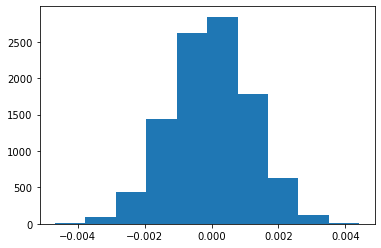

In [43]:
plt.hist(p_diffs);


**j.** What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [44]:
actual_diffe = df2[df2['group']=='treatment']['converted'].mean() - df2[df2['group']=='control']['converted'].mean()


In [45]:
(p_diffs > actual_diffe).mean()


0.9004

k. Please explain using the vocabulary you've learned in this course what you just computed in part j. What is this value called in scientific studies? What does this value mean in terms of whether or not there is a difference between the new and old pages?

is the p-value of our data sample Since the p-value is larger than our alpha which is less than 0.05, we fail to reject  H0  (null hypothesis) and accept  H1  (alternative hypothesis), statistically this means that the new treatment page does not have higher conversion rates than the old control page.

l. We could also use a built-in to achieve similar results. Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [46]:
import statsmodels.api as sm

convert_old = (df2.query("group == 'control'")['converted']).sum()
convert_new = (df2.query("group == 'treatment'")['converted']).sum()
n_old = df2.query("group == 'control'").shape[0]
n_new = df2.query("group == 'treatment'").shape[0]
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

In [51]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


**n**. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages? Do they agree with the findings in parts j. and k.?

The definition of z-score is the number of standard deviations a given data point lies from the mean.
we got z-score = 1.31 and p-value = 0.90
and the values that we computed here agrees with the findings in parts j. and k.

<a id='regression'></a>
### Part III - A regression approach

**1.** In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.


a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?



Logistic regression



**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** . to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received. Add an intercept column, as well as an ab_page column, which is 1 when an individual receives the treatment and 0 if control.

In [48]:
df2['intercept'] = 1
df2[['temp', 'ab_page']] = pd.get_dummies(df2['group'])
df2.drop('temp', axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 

In [49]:
#Loading Logit regression model
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
result = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [52]:
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 22 Dec 2021   Pseudo R-squ.:               8.077e-06
Time:                        06:55:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  



**Hints**:  What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 

- 0.1899, which is in between the p-values from part II which are 0.9066 and 0.1898, but still fails to reject  H0  (our null hypotheses).
- Because we added a new variable (ab_page) which means that we're using A/B test so we don't deal with hypotheses as we did in part II so we just check the difference in conversion rate without concedering any other values.

**f.** Now, you are considering other things that might influence whether or not an individual converts. Discuss why it is a good idea to consider other factors to add into your regression model. Are there any disadvantages to adding additional terms into your regression model?

We can incorporate more factors in our logistic regression model, but that might lead to multicollinearity, we have to ensure that the variables are independant of each other.However, a disadvantage that may occur is inaccurate results due to correlation errors. Considering all influencing factors is not easy to execute, and focusing on smaller comparisons may yield better results

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion? Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question

In [53]:
coun_df= pd.read_csv('countries.csv')
coun_df_new = coun_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
coun_df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [54]:
coun_df_new.country.unique()


array(['UK', 'US', 'CA'], dtype=object)

In [55]:
coun_df_new[['UK', 'US']]= pd.get_dummies(coun_df_new['country'])[['UK','US']]
coun_df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [56]:
coun_df_new['intercept']= 1
logist_mod = sm.Logit(coun_df_new['converted'], coun_df_new[['intercept','ab_page', 'UK', 'US']])
results = logist_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2021-12-22 06:56 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. Create the necessary additional columns, and fit the new model.

Provide the summary results, and your conclusions based on the results.

In [58]:
coun_df_new['US_inter'] = coun_df_new['US']*coun_df_new['ab_page']
coun_df_new['UK_inter'] = coun_df_new['UK']*coun_df_new['ab_page']
logist_mod = sm.Logit(coun_df_new['converted'], coun_df_new[['intercept','ab_page', 'UK', 'US'  ,'UK_inter', "US_inter" ]])
results = logist_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-12-22 07:01 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK_inter       0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US_inter       0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

### we see a small difference in decreasing of p-values , But we still are unable to reject the H0

<a id='conclusions'></a>
### conclusions


So, I can say finally say based on statistics I advice the company to stay on their old page According to the analysis I made, it turns out that the old page is better than the new one because the new page has almost same (slightly higher than the old) but not worth the change,there is an affect from CA_PAGE in converting by 1.07 more but it's useless since ab_page was not statistically significant, so we fail to reject null hypotheses